In [1]:
import os
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join("..")))
from src.data_loader import get_cleaned_data
import src.feature_engineering
importlib.reload(src.feature_engineering)
from src.feature_engineering import feature_engineering
sns.set_theme(style="whitegrid")

In [2]:
# clean_data_path = "../data/cleaned/cleaned_data.npz"
# data = np.load(clean_data_path, allow_pickle=True)
# X = data["X"] # data
# y = data["y"] # target values
# features = data["features"].tolist() # features
# time = data["time"] # time index

In [3]:
df = get_cleaned_data()
X, y, features, time = feature_engineering(df)

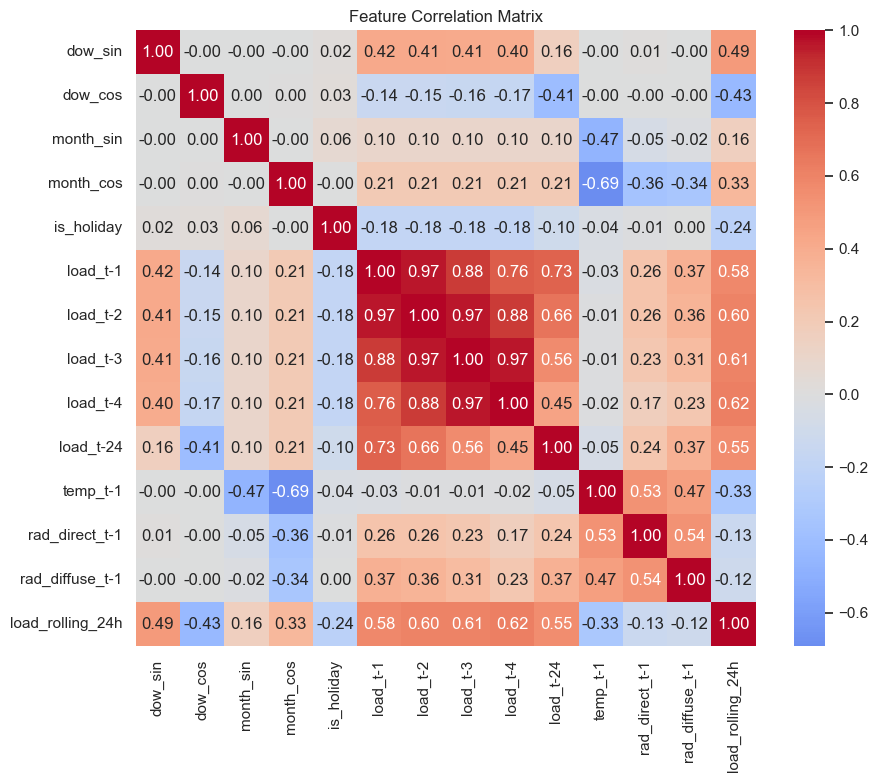

In [121]:

clean_df = pd.DataFrame(X, columns=features)
corr_matrix = clean_df[[name for name in clean_df.columns if "hour" not in name]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

In [122]:
print("Data head:\n", X[:5, :])
print("Target head:\n", y[:5])
print("Features:\n", features)
print("Time Index Head:\n", time[:5])

Data head:
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.33883739e-01
  -9.00968868e-01  5.00000000e-01  8.66025404e-01  0.00000000e+00
   5.04180000e+04  4.56790000e+04  4.23820000e+04  4.03910000e+04
   4.11330000e+04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.67760000e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000

In [123]:
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

def MAPE(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / y_true) * 100

## Linear Regression

In [124]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [125]:
# Cross-validation

tscv = TimeSeriesSplit(n_splits=5)
mae_scores, rmse_scores, mape_scores = [], [], []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = MAE(y_test, y_pred)
    rmse = RMSE(y_test, y_pred)
    mape = MAPE(y_test, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

print(f"Avg MAE: {np.mean(mae_scores):.2f} MW")
print(f"Avg RMSE: {np.mean(rmse_scores):.2f} MW")
print(f"Avg MAPE: {np.mean(mape_scores):.2f} %")

Avg MAE: 753.76 MW
Avg RMSE: 1051.15 MW
Avg MAPE: 1.39 %


In [126]:
split_idx = int(0.8 * X.shape[0])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [127]:
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae = MAE(y_test, y_pred)
rmse = RMSE(y_test, y_pred)
mape = MAPE(y_test, y_pred)

print(f"Linear Regression MAE:  {mae:.2f} MW")
print(f"Linear Regression RMSE: {rmse:.2f} MW")
print(f"Linear Regression MAPE: {mape:.2f} %")

Linear Regression MAE:  752.76 MW
Linear Regression RMSE: 1039.41 MW
Linear Regression MAPE: 1.39 %


In [128]:
coeff_df = pd.DataFrame({"Feature": features, "Coefficient": lr.coef_})
print(coeff_df.sort_values(by="Coefficient", key=abs, ascending=False))

             Feature  Coefficient
3             hour_4  3962.217505
4             hour_5  3720.328134
5             hour_6  3037.580158
7             hour_8  2649.824846
8             hour_9  2641.301628
15           hour_16  2423.533572
14           hour_15  2204.694247
6             hour_7  2202.605169
2             hour_3  2095.018475
9            hour_10  1653.605133
10           hour_11  1529.744395
12           hour_13  1527.023596
13           hour_14  1486.656617
11           hour_12  1456.215012
21           hour_22 -1216.764045
1             hour_2  1164.922847
16           hour_17  1156.148921
20           hour_21 -1138.710948
0             hour_1   697.505018
18           hour_19  -659.671557
27        is_holiday  -582.111267
19           hour_20  -434.411010
23           dow_sin   312.070627
22           hour_23  -248.463106
26         month_cos  -143.614378
17           hour_18   -57.809641
24           dow_cos   -16.447902
25         month_sin    14.594618
33          te

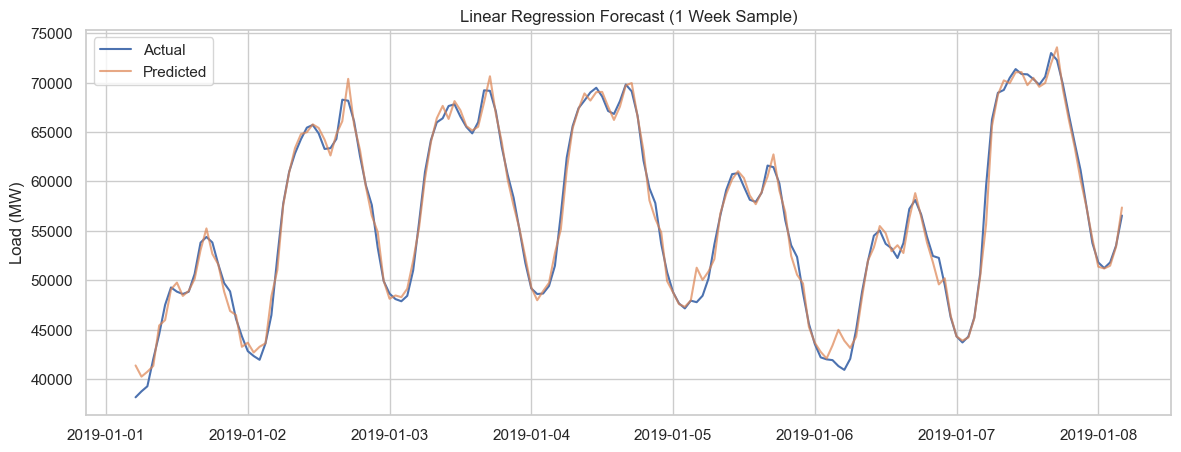

In [129]:
# Plot actual load versus predicted load for 1 week

plt.figure(figsize=(14, 5))
plt.plot(time[split_idx:split_idx+168], y_test[:168], label="Actual")
plt.plot(time[split_idx:split_idx+168], y_pred[:168], label="Predicted", alpha=0.7)
plt.title("Linear Regression Forecast (1 Week Sample)")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

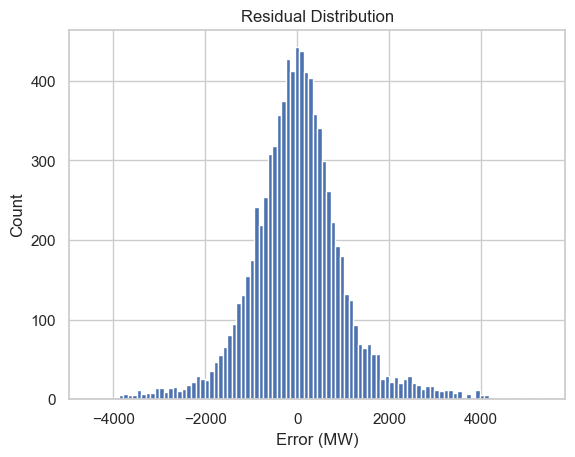

In [130]:
# plot residuals for our model
residuals = y_test - y_pred
plt.hist(residuals, bins=100)
plt.title("Residual Distribution")
plt.xlabel("Error (MW)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

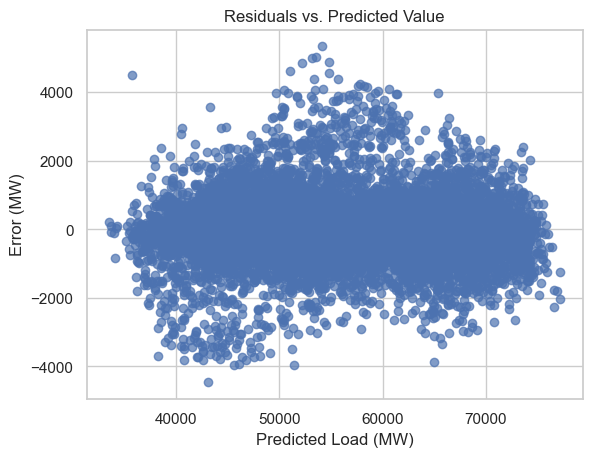

In [131]:
# check homoscedasticity
plt.scatter(y_pred, residuals, alpha=0.7)
plt.title("Residuals vs. Predicted Value")
plt.xlabel("Predicted Load (MW)")
plt.ylabel("Error (MW)")
plt.grid(True)
plt.show()

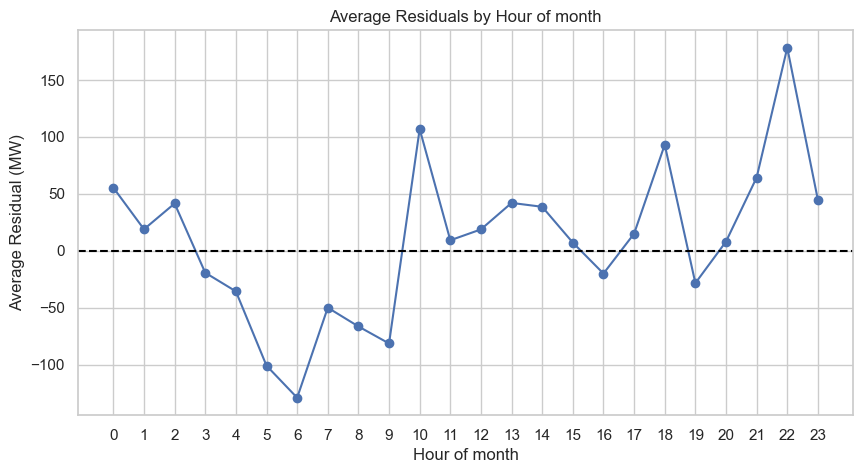

In [132]:
# check residuals over time
# residuals and hour

# hour_index = features.index("hour_sin")

res_hour = pd.DataFrame({
    "residuals": residuals,
    "hour": pd.to_datetime(time[split_idx:]).hour
}) 

hourly_mean_error = res_hour.groupby("hour")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(hourly_mean_error.index, hourly_mean_error.values, marker='o')
plt.title("Average Residuals by Hour of month")
plt.xlabel("Hour of month")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.axhline(0, color='black', linestyle='--')
plt.show()

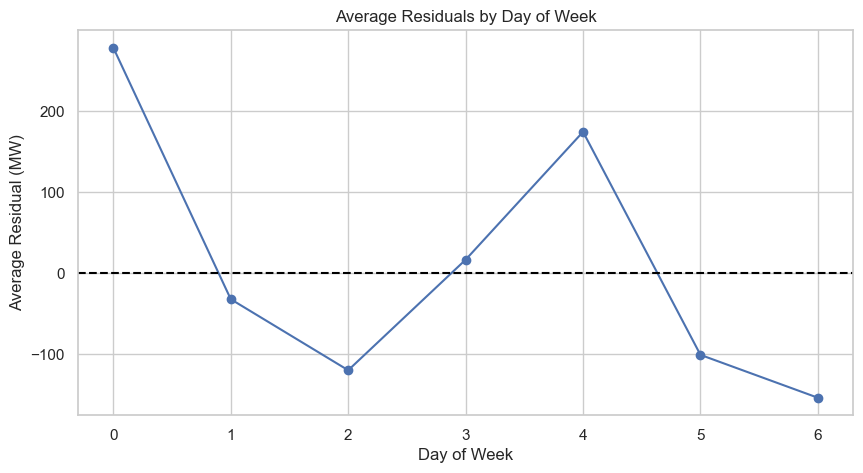

In [133]:
res_day = pd.DataFrame({
    "residuals": residuals,
    "day": pd.to_datetime(time[split_idx:]).day_of_week
}) 

daily_mean_error = res_day.groupby("day")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(daily_mean_error.index, daily_mean_error.values, marker='o')
plt.title("Average Residuals by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 7))
plt.axhline(0, color='black', linestyle='--')
plt.show()

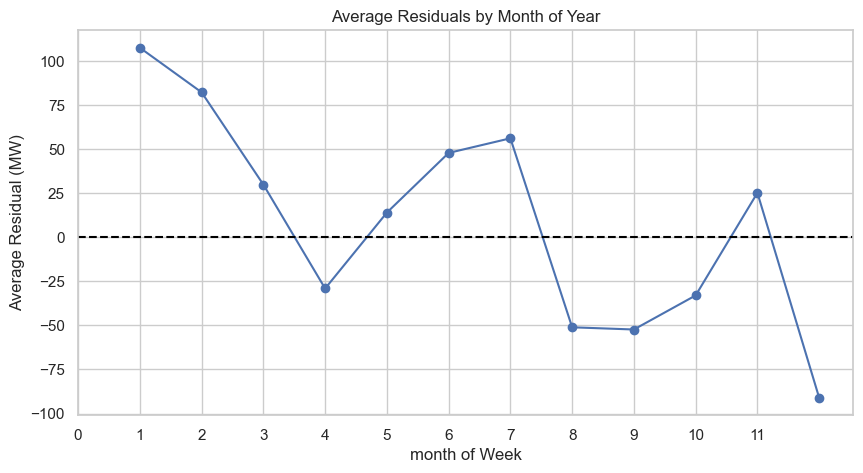

In [134]:
res_month = pd.DataFrame({
    "residuals": residuals,
    "month": pd.to_datetime(time[split_idx:]).month
}) 

monthly_mean_error = res_month.groupby("month")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_error.index, monthly_mean_error.values, marker='o')
plt.title("Average Residuals by Month of Year")
plt.xlabel("month of Week")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 12))
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [135]:
from statsmodels.stats.stattools import durbin_watson

# residuals is your array or Series of model errors
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat:.4f}")


Durbin-Watson statistic: 2.0339


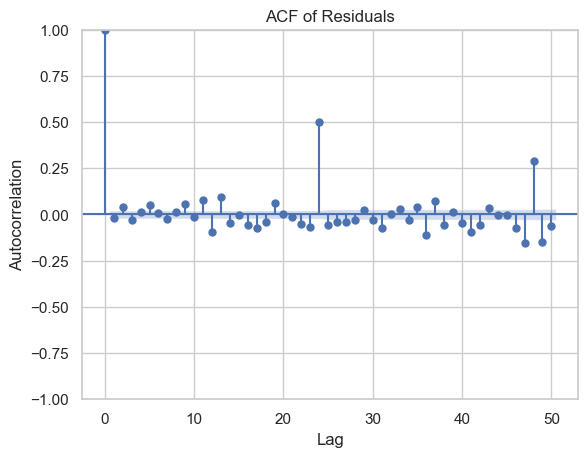

In [136]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=50)  # you can change lags as needed
plt.title("ACF of Residuals")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()


## Ridge Regression

In [137]:
tscv = TimeSeriesSplit(n_splits=5)
mae_scores, rmse_scores, mape_scores = [], [], []

alphas = [0.01, 0.1, 1]
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = make_pipeline(
        StandardScaler(),
        RidgeCV(alphas=alphas, cv=5)
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = MAE(y_test, y_pred)
    rmse = RMSE(y_test, y_pred)
    mape = MAPE(y_test, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    mape_scores.append(mape)

print(f"Avg MAE: {np.mean(mae_scores):.2f} MW")
print(f"Avg RMSE: {np.mean(rmse_scores):.2f} MW")
print(f"Avg MAPE: {np.mean(mape_scores):.2f} %")

Avg MAE: 753.67 MW
Avg RMSE: 1051.19 MW
Avg MAPE: 1.39 %


In [138]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

model = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=alphas, cv=5)
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = MAE(y_test, y_pred)
rmse = RMSE(y_test, y_pred)
mape = MAPE(y_test, y_pred)

print(f"Linear Regression MAE:  {mae:.2f} MW")
print(f"Linear Regression RMSE: {rmse:.2f} MW")
print(f"Linear Regression MAPE: {mape:.2f} %")

Linear Regression MAE:  752.67 MW
Linear Regression RMSE: 1039.37 MW
Linear Regression MAPE: 1.39 %


In [139]:
coeff_df = pd.DataFrame({"Feature": features, "Coefficient": lr.coef_})
print(coeff_df.sort_values(by="Coefficient", key=abs, ascending=False))

             Feature  Coefficient
3             hour_4  3962.217505
4             hour_5  3720.328134
5             hour_6  3037.580158
7             hour_8  2649.824846
8             hour_9  2641.301628
15           hour_16  2423.533572
14           hour_15  2204.694247
6             hour_7  2202.605169
2             hour_3  2095.018475
9            hour_10  1653.605133
10           hour_11  1529.744395
12           hour_13  1527.023596
13           hour_14  1486.656617
11           hour_12  1456.215012
21           hour_22 -1216.764045
1             hour_2  1164.922847
16           hour_17  1156.148921
20           hour_21 -1138.710948
0             hour_1   697.505018
18           hour_19  -659.671557
27        is_holiday  -582.111267
19           hour_20  -434.411010
23           dow_sin   312.070627
22           hour_23  -248.463106
26         month_cos  -143.614378
17           hour_18   -57.809641
24           dow_cos   -16.447902
25         month_sin    14.594618
33          te

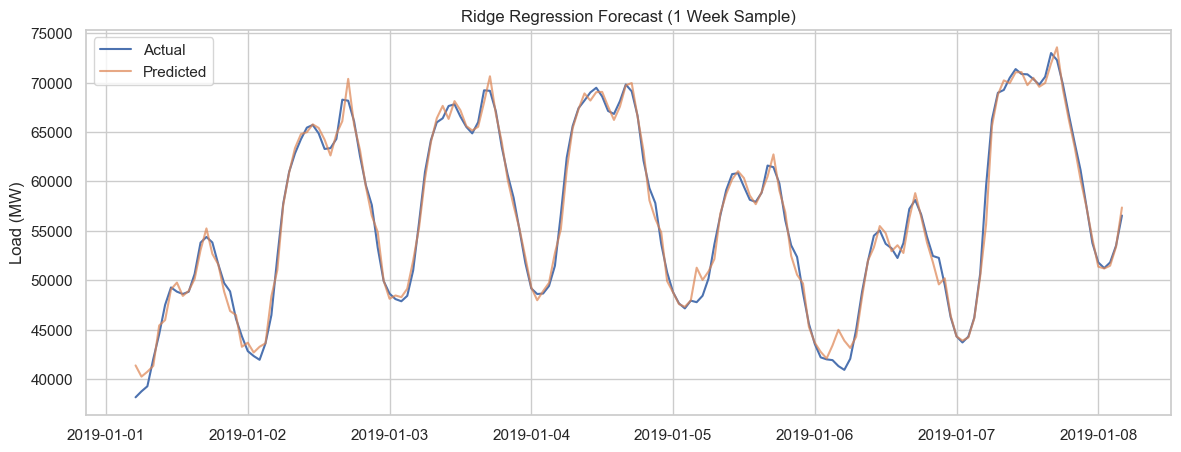

In [140]:
# Plot actual load versus predicted load for 1 week

plt.figure(figsize=(14, 5))
plt.plot(time[split_idx:split_idx+168], y_test[:168], label="Actual")
plt.plot(time[split_idx:split_idx+168], y_pred[:168], label="Predicted", alpha=0.7)
plt.title("Ridge Regression Forecast (1 Week Sample)")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

## Random Forests

In [141]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer

In [142]:
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": [1, "sqrt", None]
}

mae_scorer = make_scorer(MAE, greater_is_better=False)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring=mae_scorer,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)
print(f"Best validation MAE: {-grid_search.best_score_:.2f} MW")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best validation MAE: 497.29 MW


In [143]:
split_idx = int(0.8 * X.shape[0])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [144]:
rf = RandomForestRegressor(
    max_depth=None,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mae = MAE(y_test, y_pred)
rmse = RMSE(y_test, y_pred)
mape = MAPE(y_test, y_pred)

print(f"Linear Regression MAE:  {mae:.2f} MW")
print(f"Linear Regression RMSE: {rmse:.2f} MW")
print(f"Linear Regression MAPE: {mape:.2f} %")

Linear Regression MAE:  443.57 MW
Linear Regression RMSE: 599.16 MW
Linear Regression MAPE: 0.81 %


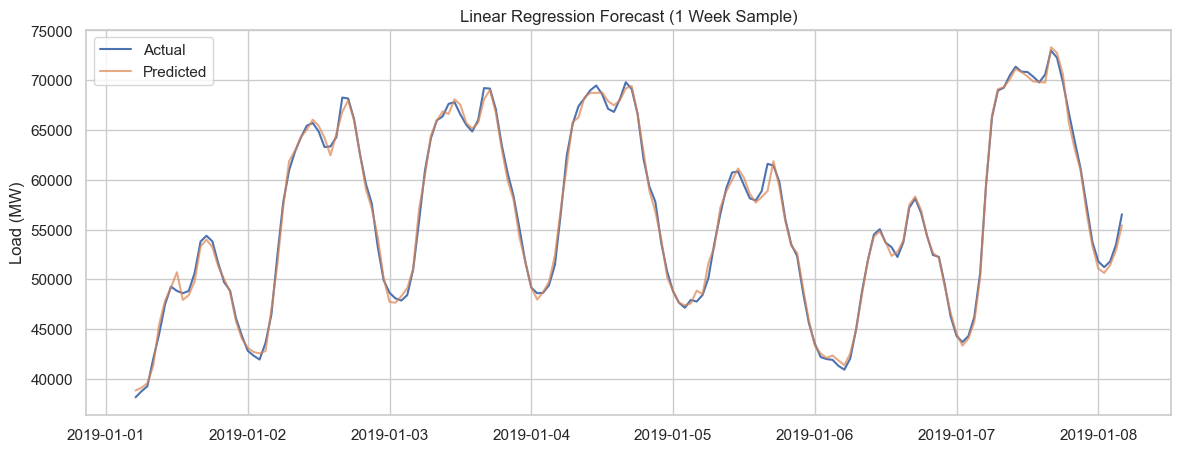

In [145]:
# Plot actual load versus predicted load for 1 week

plt.figure(figsize=(14, 5))
plt.plot(time[split_idx:split_idx+168], y_test[:168], label="Actual")
plt.plot(time[split_idx:split_idx+168], y_pred[:168], label="Predicted", alpha=0.7)
plt.title("Linear Regression Forecast (1 Week Sample)")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

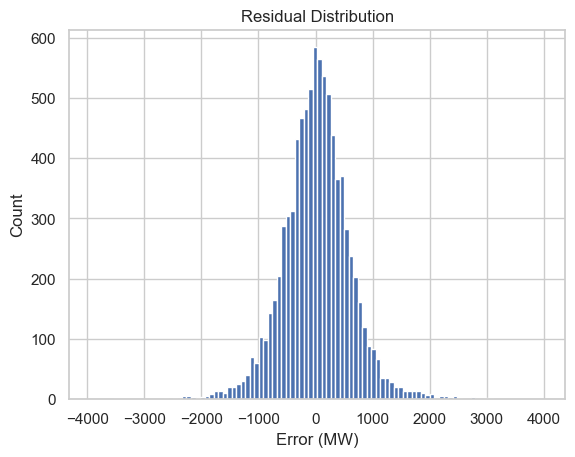

In [146]:
# plot residuals for our model
residuals = y_test - y_pred
plt.hist(residuals, bins=100)
plt.title("Residual Distribution")
plt.xlabel("Error (MW)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

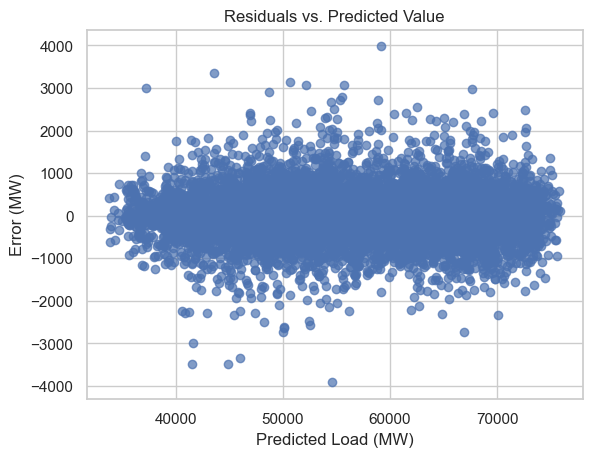

In [147]:
# check homoscedasticity
plt.scatter(y_pred, residuals, alpha=0.7)
plt.title("Residuals vs. Predicted Value")
plt.xlabel("Predicted Load (MW)")
plt.ylabel("Error (MW)")
plt.grid(True)
plt.show()

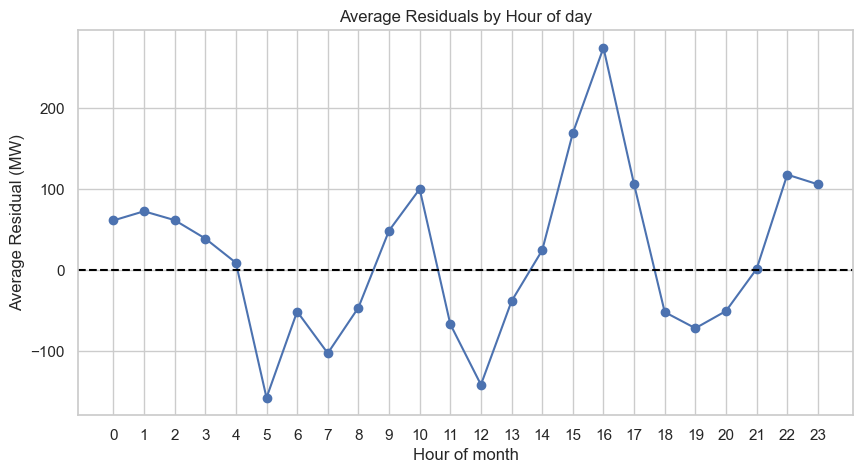

In [148]:
# check residuals over time
# residuals and hour

# hour_index = features.index("hour_sin")

res_hour = pd.DataFrame({
    "residuals": residuals,
    "hour": pd.to_datetime(time[split_idx:]).hour
}) 

hourly_mean_error = res_hour.groupby("hour")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(hourly_mean_error.index, hourly_mean_error.values, marker='o')
plt.title("Average Residuals by Hour of day")
plt.xlabel("Hour of month")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.axhline(0, color='black', linestyle='--')
plt.show()

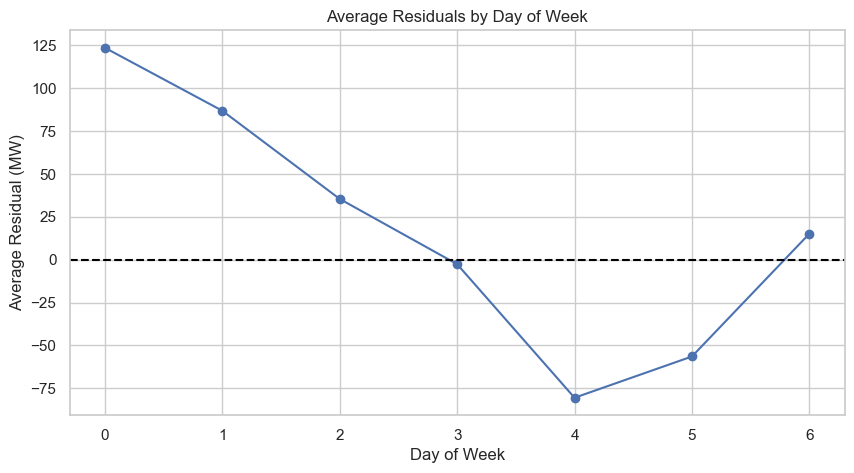

In [149]:
res_day = pd.DataFrame({
    "residuals": residuals,
    "day": pd.to_datetime(time[split_idx:]).day_of_week
}) 

daily_mean_error = res_day.groupby("day")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(daily_mean_error.index, daily_mean_error.values, marker='o')
plt.title("Average Residuals by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 7))
plt.axhline(0, color='black', linestyle='--')
plt.show()

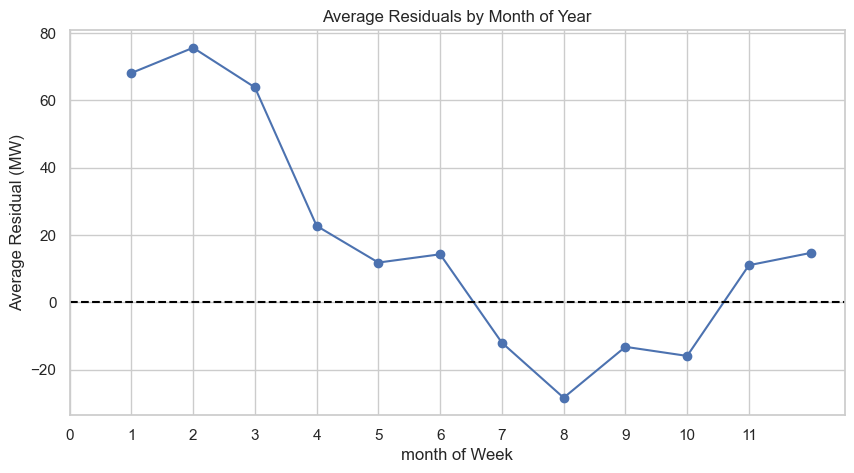

In [150]:
res_month = pd.DataFrame({
    "residuals": residuals,
    "month": pd.to_datetime(time[split_idx:]).month
}) 

monthly_mean_error = res_month.groupby("month")['residuals'].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_error.index, monthly_mean_error.values, marker='o')
plt.title("Average Residuals by Month of Year")
plt.xlabel("month of Week")
plt.ylabel("Average Residual (MW)")
plt.grid(True)
plt.xticks(range(0, 12))
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [151]:
# residuals is your array or Series of model errors
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat:.4f}")


Durbin-Watson statistic: 1.7819


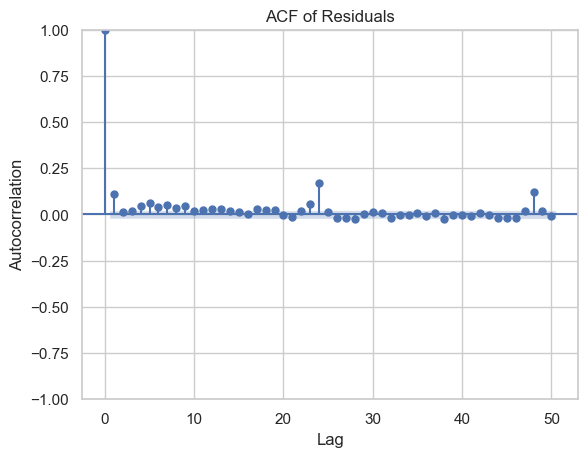

In [152]:
plot_acf(residuals, lags=50)  # you can change lags as needed
plt.title("ACF of Residuals")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

## XGBoost

In [153]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor

# Define your model
xgb = XGBRegressor(objective='reg:squarederror', n_jobs=-1)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',  # or 'neg_root_mean_squared_error'
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X, y)

# Best hyperparameters
print("Best params:", grid_search.best_params_)
print("Best MAE:", -grid_search.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best MAE: 452.1155334388748


In [154]:
split_idx = int(0.8 * X.shape[0])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [155]:
xgb_model = XGBRegressor(
    objective="reg:squared_error",
    colsample_bytree = 1.,
    learning_rate=0.1,
    max_depth=None,
    n_estimators=500,
    subsample=0.8,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mae = MAE(y_test, y_pred)
rmse = RMSE(y_test, y_pred)
mape = MAPE(y_test, y_pred)

print(f"Linear Regression MAE:  {mae:.2f} MW")
print(f"Linear Regression RMSE: {rmse:.2f} MW")
print(f"Linear Regression MAPE: {mape:.2f} %")

Linear Regression MAE:  443.57 MW
Linear Regression RMSE: 599.16 MW
Linear Regression MAPE: 0.81 %


In [16]:
import src.model
importlib.reload(src.model)
import src.feature_engineering
importlib.reload(src.feature_engineering)
from src.model import LoadDataSet, LSTMForecast, train_lstm, test_lstm
from src.feature_engineering import feature_engineering_lstm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader

In [17]:
X, y, features, time = feature_engineering_lstm(df)

split_idx = int(0.8 * X.shape[0])
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [18]:
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

In [19]:
X_train_small = X_train[:int(X_train.shape[0]*.2)]
y_train_small = y_train[:int(X_train.shape[0]*.2)]
seq_len = 24
small_train_dataset = LoadDataSet(X_train_small, y_train_small, seq_len)
small_train_loader = DataLoader(small_train_dataset, batch_size=32, shuffle=False)

small_model = LSTMForecast(
    input_size=X_train.shape[1],
    hidden_size=50,
    num_layers=2,
    output_size=1
)

num_epochs = 10
lrs = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
best_lr = None
best_mse = np.inf
for lr in lrs:
    optimizer_params = {"lr": lr}
    loss = train_lstm(small_model, small_train_loader, optimizer_params, num_epochs)
    if loss < best_mse:
        best_mse = loss
        best_lr = lr
    print("Finished LR, MSE:", lr, loss)

print("Best LR, MSE:", best_lr, best_mse) 

cpu
Epoch [10/10], Loss: 0.0088
Finished LR, MSE: 0.0001 0.008787394061221287
cpu
Epoch [10/10], Loss: 0.0019
Finished LR, MSE: 0.0005 0.0018503537586086038
cpu
Epoch [10/10], Loss: 0.0013
Finished LR, MSE: 0.001 0.001294185976461983
cpu
Epoch [10/10], Loss: 0.0012
Finished LR, MSE: 0.005 0.0011669378106893083
cpu
Epoch [10/10], Loss: 0.0010
Finished LR, MSE: 0.01 0.0010217456392344379
cpu
Epoch [10/10], Loss: 0.0023
Finished LR, MSE: 0.05 0.0023455899215471757
cpu
Epoch [10/10], Loss: 0.0035
Finished LR, MSE: 0.1 0.003522104233882933
Best LR, MSE: 0.01 0.0010217456392344379


In [ ]:
seq_len = 24
train_dataset = LoadDataSet(X_train, y_train, seq_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

model = LSTMForecast(
    input_size=X_train.shape[1],
    hidden_size=50,
    num_layers=2,
    output_size=1
)

num_epochs = 10
optimizer_params = {"lr": 0.01}
train_lstm(model, train_loader, optimizer_params, num_epochs)

cpu
Epoch [10/10], Loss: 0.0019


0.0018879914357801837

In [25]:
test_dataset = LoadDataSet(X_test, y_test, seq_len)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

preds_inv, trues_inv, _ = test_lstm(model, test_loader, scaler_y)

RMSE: 3738.30
MAE: 2937.37
MAPE: 0.05%


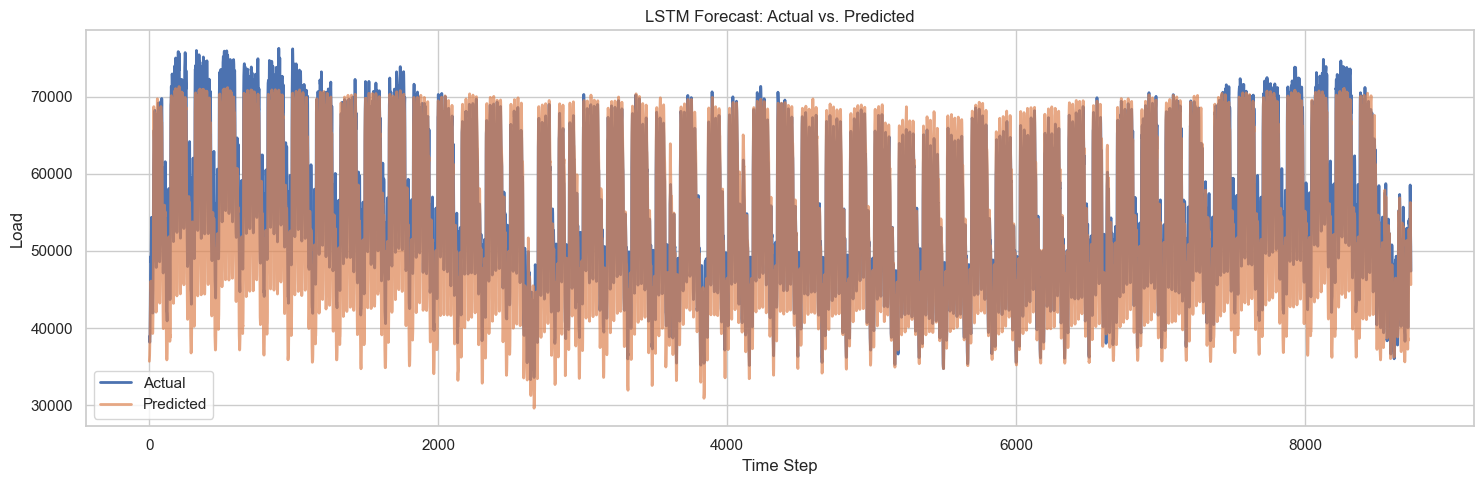

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(trues_inv, label='Actual', linewidth=2)
plt.plot(preds_inv, label='Predicted', linewidth=2, alpha=0.7)
plt.title('LSTM Forecast: Actual vs. Predicted')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

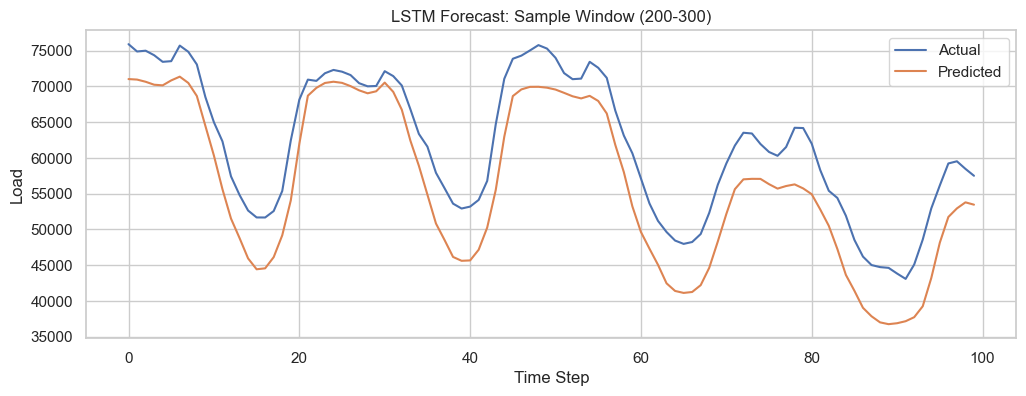

In [27]:
start = 200
end = 300

plt.figure(figsize=(12, 4))
plt.plot(trues_inv[start:end], label='Actual')
plt.plot(preds_inv[start:end], label='Predicted')
plt.title(f'LSTM Forecast: Sample Window ({start}-{end})')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.show()


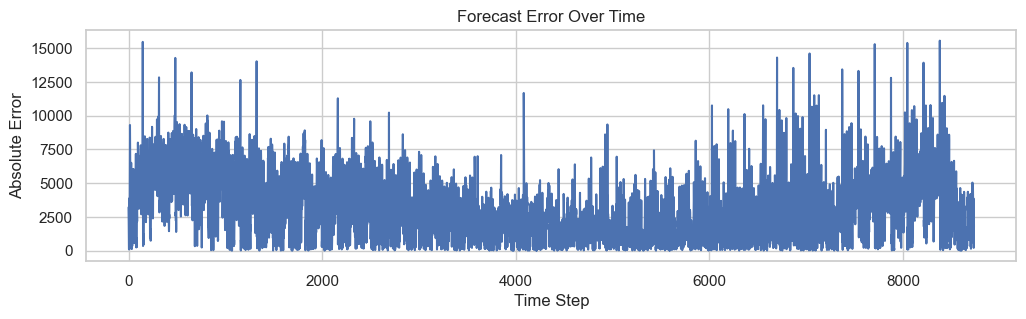

In [28]:
errors = np.abs(preds_inv - trues_inv)

plt.figure(figsize=(12, 3))
plt.plot(errors, label='Absolute Error')
plt.title('Forecast Error Over Time')
plt.xlabel('Time Step')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.show()


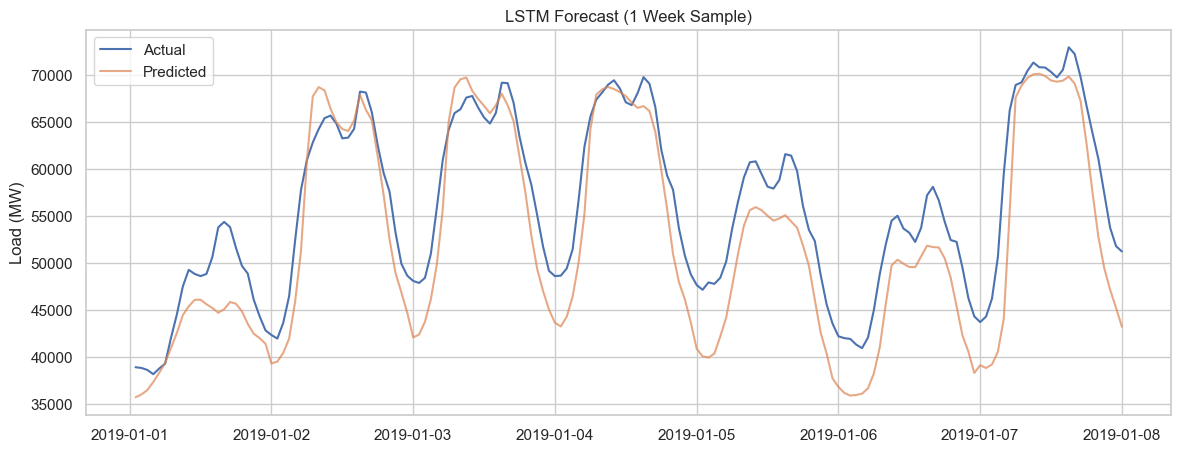

In [30]:
# Plot actual load versus predicted load for 1 week

plt.figure(figsize=(14, 5))
plt.plot(time[split_idx:split_idx+168], trues_inv[:168], label="Actual")
plt.plot(time[split_idx:split_idx+168], preds_inv[:168], label="Predicted", alpha=0.7)
plt.title("LSTM Forecast (1 Week Sample)")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()